In [7]:
from google.cloud import bigquery

import pandas as pd
import numpy as np
import math

from scipy import stats

from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot  as plt

from google.oauth2 import service_account


In [8]:
IstrainData=True
imported_to='2023-06-21' 

threshold_x_sd = 3  # 2x-4x

In [9]:

projectId='smart-data-ml'

dw_dataset_id="SMartDW"
dw_table_id = f"{projectId}.{dw_dataset_id}.incident"

dataset_id='SMartML'


credentials = service_account.Credentials.from_service_account_file(r'C:\Windows\smart-data-ml-91b6f6204773.json')
client = bigquery.Client(credentials=credentials, project=projectId)
#client = bigquery.Client(project=projectId)

def load_data_bq(sql:str):

 query_result=client.query(sql)
 df_all=query_result.to_dataframe()
 return df_all


In [5]:
# Build Train/Test Data


train_name='train2_incident'
test_name='test2_incident'
train_table_id=f"{projectId}.{dataset_id}.{train_name}"
test_tabel_id=f"{projectId}.{dataset_id}.{test_name}"
print(f"TrainTable2={train_table_id} and TestTable2={test_tabel_id}")



TrainTable2=smart-data-ml.SMartML.train2_incident and TestTable2=smart-data-ml.SMartML.test2_incident


In [6]:
label='severity_id'
labelName='severity_name'

removeCols=['id','updated_at','imported_at']

dateCols=['open_datetime','close_datetime','response_datetime','resolved_datetime']
numbericCols=['open_to_close_hour','response_to_resolved_hour']
rangeCols=[]
cateCols=['sla','product_type','brand','service_type','incident_type']

# Explore and Transform Data

In [95]:
# if IstrainData:

sql_all=f"""
SELECT  id,severity_id,severity_name
,sla,product_type,brand,service_type,incident_type
,open_datetime,  close_datetime, response_datetime,resolved_datetime
,updated_at,imported_at
FROM `{dw_table_id}`    
WHERE imported_at< '{imported_to}'
"""

print(sql_all)

print("Load data from Bigquery")
df_all=load_data_bq(sql_all)

df_all=df_all.drop_duplicates(subset=['id'],keep='last')

no_original_rows=len(df_all)

if len(df_all)==0:
 print("No records from bigquery")  
 quit()
else:
 print(df_all.shape)  
print(df_all[["severity_id","severity_name","updated_at","imported_at"]].head())


SELECT  id,severity_id,severity_name
,sla,product_type,brand,service_type,incident_type
,open_datetime,  close_datetime, response_datetime,resolved_datetime
,updated_at,imported_at
FROM `smart-data-ml.SMartDW.incident`    
WHERE imported_at<= '2023-06-20'

Load data from Bigquery
(2773, 14)
   severity_id severity_name          updated_at                imported_at
0            2         Major 2022-12-06 11:02:41 2023-02-22 16:41:28.740783
1            3         Minor 2022-12-06 10:58:22 2023-02-22 16:41:28.740783
2            2         Major 2022-12-01 12:14:25 2023-02-22 16:41:28.740783
3            2         Major 2022-12-01 09:29:20 2023-02-22 16:41:28.740783
4            2         Major 2022-12-01 16:36:35 2023-02-22 16:41:28.740783


# Manage Numberic Cols
### 1-Find Time Inverval
### 2-Remove outlier on Time Interval to service
### 3-Find any rows  contain zero time period
### 4-Create range from time-interval (best,good,moderate,bad,worst)

# Bining Range

function is used to separate the array elements into many different ranges . 
The cut function is mainly used to perform statistical analysis on scalar data. 

we can convert hour to range   
* (0, 24] =by 1 day =best
* (24, 168] =  1day -1 week  =good
* (168, 360]=  1week- 15 days(half a month) =fair
* (360, 720]= 15 dasy-1 month =bad
* (720, 2349]=1 month-1 Q =worst

open_to_close_hour ,response_to_resolved_hour , Mostly  we can complate by 1 day (0, 24]
there are few cases that take long to close incident (360, 720]   15 day to  1month

In [96]:
start_end_list=[ ['open_datetime','close_datetime'],['response_datetime','resolved_datetime']]
listDiffDateDeltaCols=[]
listDiffHourCols=[]
for item  in  start_end_list:
   diff_str=f"{item[0]}_to_{item[1]}" 
   diff_str=diff_str.replace('_datetime','')  
   listDiffDateDeltaCols.append(diff_str)
   df_all[diff_str]=df_all[item[1]]-df_all[item[0]]
    
   diff_hour=f'{diff_str}_hour'
   listDiffHourCols.append(diff_hour)
   df_all[diff_hour] = df_all[diff_str].apply(lambda x:  x.total_seconds() / (60*60) if x is not np.nan else np.nan  )


# https://www.geeksforgeeks.org/z-score-for-outlier-detection-python/
xScoreDiffHourCols=[]
for col in listDiffHourCols:
  z_col=f"zscore_{col}"   
  df_all[z_col] = np.abs(stats.zscore(df_all[col]))   
  xScoreDiffHourCols.append(z_col)  
#remove oulier

for col in  xScoreDiffHourCols:
  df_all=df_all.query(f"{col}<@threshold_x_sd")


allRows=df_all.shape[0]
for col in numbericCols:
    zeroRows=len(df_all.query(f"{col}==0"))
    pctZeroHour=round(zeroRows/allRows*100,1)
    print(f"No. 0-hour row on {col} = {zeroRows}({pctZeroHour} %)")
    df_all=df_all.query(f'{col}!=0')
    
def service_hour_range(x_hour):
    if x_hour>0 and x_hour<=24:
      return "best"
    elif x_hour>25 and x_hour<=168:
      return "good"
    elif x_hour>168 and x_hour<=360:
      return "moderate"
    elif x_hour>360 and x_hour<=720:
      return "bad"
    else:
      return "worst"

for col in numbericCols:
    range_col=f"range_{col}"
    rangeCols.append(range_col)
    df_all[range_col]=df_all[col].apply(service_hour_range)
    
removeCols=removeCols+dateCols+xScoreDiffHourCols+listDiffDateDeltaCols
print(f"Remove {removeCols}")
df_all=df_all.drop(columns=removeCols)
no_rows_after_removing_outlier=len(df_all)
pct_row_decrease=round( (no_original_rows-no_rows_after_removing_outlier)/no_original_rows*100 ,0)

print(f"% remove data {pct_row_decrease}")

print(df_all.info())


# df_all[listDiffHourCols].describe(percentiles=[.95,.75,.50,.25,.05]).drop(index=['count','std'])

No. 0-hour row on open_to_close_hour = 1(0.0 %)
No. 0-hour row on response_to_resolved_hour = 137(5.0 %)
Remove ['id', 'updated_at', 'imported_at', 'open_datetime', 'close_datetime', 'response_datetime', 'resolved_datetime', 'zscore_open_to_close_hour', 'zscore_response_to_resolved_hour', 'open_to_close', 'response_to_resolved']
% remove data 6.0
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2595 entries, 0 to 2798
Data columns (total 11 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   severity_id                      2595 non-null   Int64  
 1   severity_name                    2595 non-null   object 
 2   sla                              2595 non-null   object 
 3   product_type                     2595 non-null   object 
 4   brand                            2595 non-null   object 
 5   service_type                     2595 non-null   object 
 6   incident_type                    2595 non-n

In [97]:
# # https://www.geeksforgeeks.org/pandas-cut-method-in-python/
# def explore_ranges_numberic_val(col,rangeList):
#     print(col)
#     rangeList.sort()
#     return pd.cut(df_all[col],rangeList, right=True).value_counts()
# range1= [0,24, 168, 360, 720,math.floor(df_all['open_to_close_hour'].max())]
# print(explore_ranges_numberic_val('open_to_close_hour',range1))
# print("=======================================================")

# range2= [0,24, 168, 360, 720,math.floor(df_all['response_to_resolved_hour'].max())]
# print(explore_ranges_numberic_val('response_to_resolved_hour',range2))
# print("=======================================================")



# Plot Numeric  and Category columns

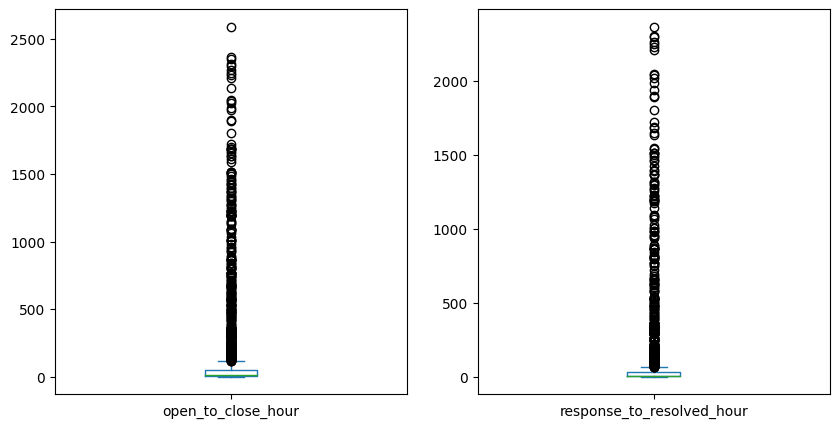

In [98]:
df_all[numbericCols].plot(kind='box',subplots=True,layout=(1,len(numbericCols)),sharex=False, sharey=False,figsize=(10,5))
plt.show()

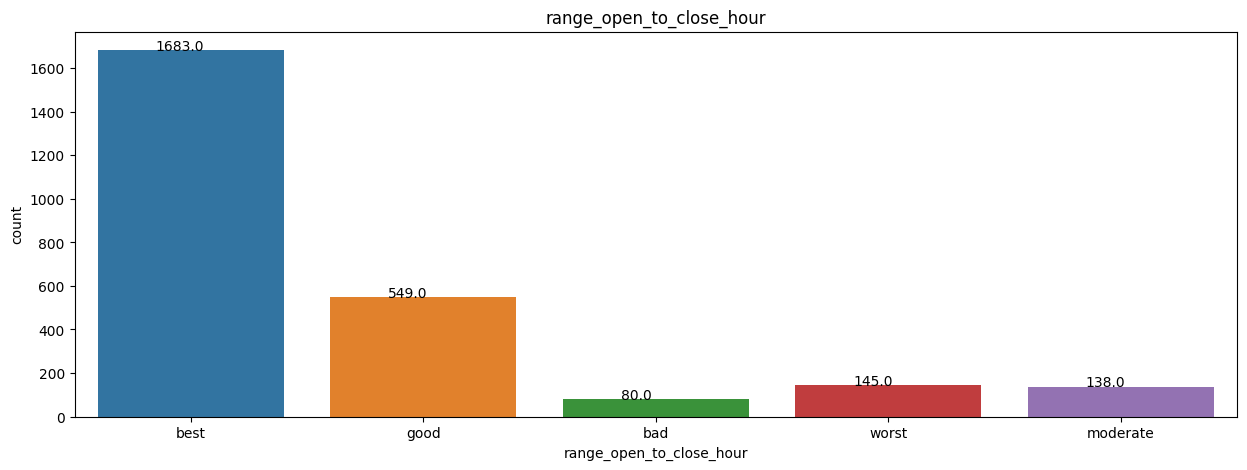

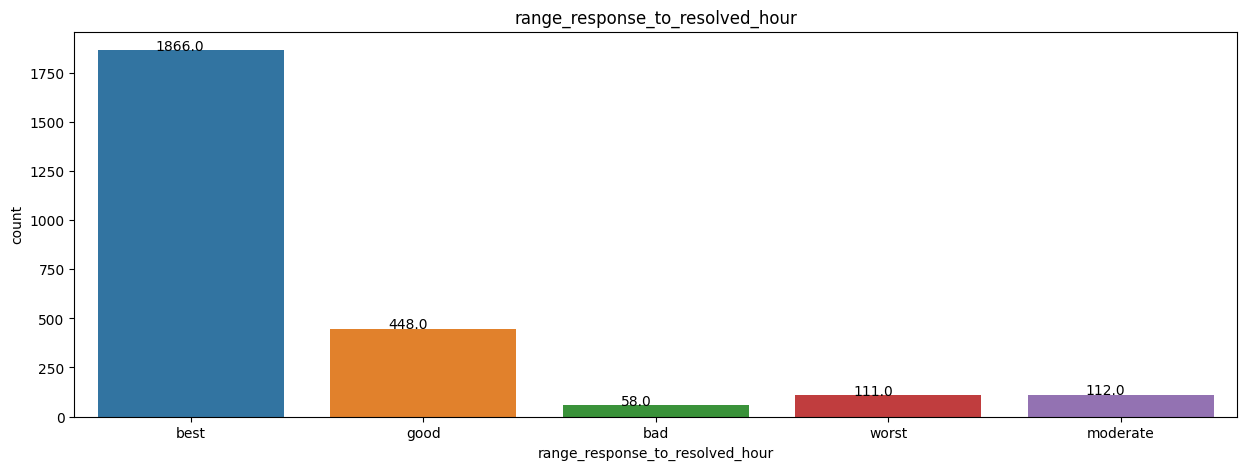

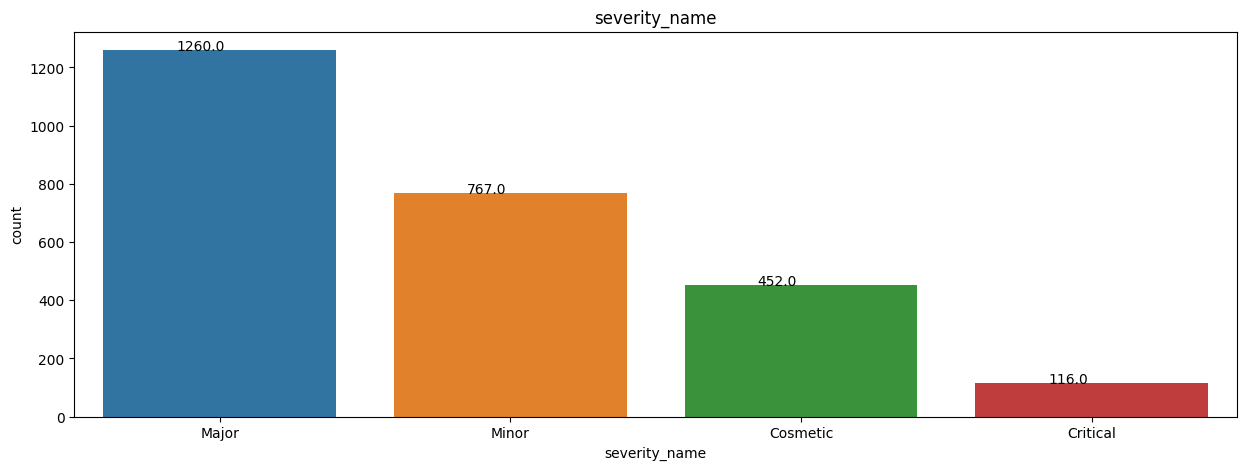

In [99]:
barCols=rangeCols+["severity_name"]
for col in barCols:
    fig , ax = plt.subplots(figsize=(15,5))
    ax =sns.countplot(x=col, data=df_all,)
    for p in ax.patches:
       ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))
    plt.title(col)
    plt.show()

# Build Training DataSet

In [100]:
# create label
map_severity_to_class={4:0,3: 1, 2: 2, 1: 3}
print(f"Map severity id to LabelCode: {str(map_severity_to_class)}")

Map severity id to LabelCode: {4: 0, 3: 1, 2: 2, 1: 3}


In [101]:
df_all['label_multi_severity'] =df_all['severity_id'].map(map_sevirity_to_class) 
def map_4to2_serverity(severity_id):
    if severity_id==1 or severity_id==2:
       return 1
    else:
       return 0 
df_all['label_binary_severity'] =df_all['severity_id'].apply(map_4to2_serverity)

print( list(df_all['label_multi_severity'].unique()))
print(df_all['label_binary_severity'].unique())
df_all.head()

[2, 1, 0, 3]
[1 0]


,severity_id,severity_name,sla,product_type,brand,service_type,incident_type,open_to_close_hour,response_to_resolved_hour,range_open_to_close_hour,range_response_to_resolved_hour,label_multi_severity,label_binary_severity
0,2,Major,24x7 6Hrs Resolution Time,Server,HPE,Incident,Hard Disk Drive Failure,4.416667,3.000000,best,best,2,1
1,3,Minor,24x7 6Hrs Resolution Time,Server,HPE,Incident,Power Supply Failure,5.400000,2.000000,best,best,1,0
2,2,Major,24x7 4Hrs Resolution Time,Server,HPE,Incident,General Incident,21.133333,1.900000,best,best,2,1
3,2,Major,9x5xNBD 4Hrs Response Time,Server,HPE,Incident,General Incident,7.100000,6.966667,best,best,2,1
4,2,Major,24x7 4Hrs Resolution Time,Software,VMWare,Incident,Software,19.116667,19.016667,best,best,2,1


In [102]:
#Split data into 2 dataset to BQ
len_all=len(df_all)
print(f"All Data = {len_all}")

# Split the 80% of total as train
# The remaining  will be splited equally 50% for valuation and the rest of later part is test

train, test = train_test_split(df_all,test_size=0.2,random_state=1000,shuffle=True)

len_all=len(df_all)
len_train=len(train)

len_test=len(test)
print(f'{len_train} =train examples ({round(len_train/len_all*100,1)}%)')
print(f'{len_test} =test examples ({round(len_test/len_all*100,1)}%)')

All Data = 2595
2076 =train examples (80.0%)
519 =test examples (20.0%)


In [103]:
print(f"pct removed data ={(no_original_rows-len(df_all))/no_original_rows*100}")
#it is pretty close to 5%   , at most 10% is removable

pct removed data =6.419040750090154


In [104]:
def loadDataFrameToBQ(table_id,dfx):
    try:
        job_config = bigquery.LoadJobConfig(
            write_disposition="WRITE_TRUNCATE",
        )

        job = client.load_table_from_dataframe(
            dfx, table_id, job_config=job_config
        )
        job.result()  # Wait for the job to complete.
        print(f"{len(dfx)} rows imported to {table_id} successfully")

    except BadRequest as e:
        print("Bigquery Error\n")
        for e in job.errors:
            print('ERROR: {}'.format(e['message']))
            
#save to csv file to load faster than bigquery
train.to_csv(f"data/{train_name}.csv",index=False)
test.to_csv(f"data/{test_name}.csv",index=False)

#write_disposition="WRITE_TRUNCATE"
#google will create table and load data into them automaticall 
loadDataFrameToBQ(f"{train_table_id}",train)
loadDataFrameToBQ(f"{test_tabel_id}",test)   
    

2076 rows imported to smart-data-ml.SMartML.train2_incident successfully
519 rows imported to smart-data-ml.SMartML.test2_incident successfully
